### Marketing Campaign Results

Download Datasets
This data project has been used as a take-home assignment in the recruitment process for the data science positions at Freedom Debt Relief.

Freedom Debt Relief’s customers are people who have a substantial amount of debt and because of an unexpected hardship, are no longer able to make their minimum monthly payments. Upon enrolling in Freedom’s Debt Relief program, customers cease making payments to their creditors and instead make deposits they can afford into a new dedicated bank account with Freedom. Freedom uses these funds to negotiate with each of the client’s creditors to settle the debt, typically at only a fraction of what was originally owed. Once a settlement has been agreed upon for an individual account, Freedom facilitates payments from the dedicated bank account to the creditor based on the terms of the settlement agreement. Freedom then collects fees from the client for the individual account that was settled. Freedom earns fees for each account it successfully negotiates a settlement agreement. The number of settlement agreements Freedom can negotiate is proportional to the monthly deposited amount. Assume industry statistics for any analysis input that you would want to use that is not provided here, including but not limited to fee percentage Freedom would collect along with ongoing cost per client between initial enrollment and program graduation.

Assignment
Imagine that Freedom ran a recent marketing campaign to promote the value proposition of how the debt relief program helps people achieve financial freedom. Assume the cost of this campaign was $5 million. There are five months of data in the datasets provided. Let’s say campaign took place over the course of the third month. You now want to show the marketing, sales and operations teams just how successful this campaign was.

Using the three datasets given:

Provide a quantitative assessment of whether the marketing campaign was successful. How and why did you choose your specific success metric(s)?
Based on the provided data, how would you recommend campaign strategy be adjusted in the future to improve performance?
How do you think campaign performance would have changed if we did not run the campaign in Month 3, but instead postponed it until month 6? Provide an incremental number versus your result in Question #1.
Data Description
Attached you will find three files with the data you will need to complete the analysis.

client_data.csv: You will find data specific to fictional clients

client_id: Randomly generated unique surrogate identifier for a client
client_geographical_region: Client geographical location in relation to U.S. Census definitions
client_residence_status: Client residence status in relation to whether they rent or own
client_age: Client age in relation to date of birth
deposit_data.csv: You will find data specific to the client deposit behavior

client_id: Randomly generated unique surrogate identifier for a client
deposit_type: Delineates whether a client deposit is the scheduled record or actual record
deposit_amount: Client deposit amount to the dedicated bank account with Freedom
deposit_cadence: Timing and pattern of client deposit activity
deposit_date: Deposit date for deposit type
calendar_data.csv: This is a calendar reference table

gregorian_date: This date aligns with the Gregorian calendar
month_name: These are the designated months in the case study
Month 1 and 2 are pre-campaign
Month 3 is the campaign
Month 4 and 5 are post-campaign
Note: These datasets were created for this analytical exercise and are only intended to be used to assess the critical thinking and technical abilities of interview candidates. This data purposely does not reflect actual client or deposit information. No inferences should be made from this information in regard to Freedom’s client base, deposit activity, company size or company growth trajectory.

Practicalities
You are free to use any tool or means you would like to highlight your abilities, but we would like to see something more advanced than Excel pivot tables, for example. Not only your ability to provide the correct results is important, but also how you decide to visualize and explain your results.

Assume the following:

There is no seasonality in the results, and the campaign spend was distributed evenly across Month 3 (i.e., spend on the first day is the same as spend on the last day).
Channel mix, targeting, and efficiency are outside the scope of this exercise, but you may address it after answering the 3 questions.
There may be data provided that is not useful in your analysis.

https://platform.stratascratch.com/data-projects/marketing-campaign-results

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [49]:
# Import Data


df_client = pd.read_csv('./notebooks/data/freedom_loans/client_data.csv')
df_deposit = pd.read_csv('./notebooks/data/freedom_loans/deposit_data.csv')
df_calendar = pd.read_csv('./notebooks/data/freedom_loans/calendar_data.csv')


df_client.head()

,client_id,client_geographical_region,client_residence_status,client_age
0,538839486596724,Northeast,Rent,91
1,321708286091707,West,Own,83
2,848531901757235,Midwest,Own,84
3,854405182328779,Northeast,Own,83
4,769102176031316,West,Own,85


In [50]:

df_deposit.head()

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date
0,446495122764671,Actual Deposit,303.0,Monthly,2019-10-23
1,446495122764671,Actual Deposit,303.0,Monthly,2019-09-23
2,446495122764671,Scheduled Deposit,303.0,Monthly,2019-09-23
3,446495122764671,Scheduled Deposit,303.0,Monthly,2019-10-23
4,446495122764671,Scheduled Deposit,303.0,Monthly,2019-06-23


In [51]:
df_deposit['deposit_date'] = pd.to_datetime(df_deposit['deposit_date'])
df_deposit['yr_month'] = df_deposit['deposit_date'].dt.strftime('%Y-%m')
df_deposit['month'] = df_deposit['deposit_date'].dt.month



df_deposit.head()

df_calendar['gregorian_date'] = pd.to_datetime(df_calendar['gregorian_date'])

# Adding the campaign month reference to the deposits data
df_deposit = df_deposit.merge(df_calendar,
                              how='left',
                              left_on=['deposit_date'],
                              right_on=['gregorian_date'])

def campaign_marker_assign(m):
    if m in (['Month 1', 'Month 2']):
        label = 'pre campaign'
    elif m == 'Month 5':
        label = 'campaign'
    else:
        label = 'post campaign'

    return label

df_deposit['campaign_date_markers'] = df_deposit['month_name'].apply(lambda x: campaign_marker_assign(x) if not pd.isna(x) else np.nan)

df_deposit.head()

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,yr_month,month,gregorian_date,month_name,campaign_date_markers
0,446495122764671,Actual Deposit,303.0,Monthly,2019-10-23,2019-10,10,2019-10-23,Month 5,campaign
1,446495122764671,Actual Deposit,303.0,Monthly,2019-09-23,2019-09,9,2019-09-23,Month 4,post campaign
2,446495122764671,Scheduled Deposit,303.0,Monthly,2019-09-23,2019-09,9,2019-09-23,Month 4,post campaign
3,446495122764671,Scheduled Deposit,303.0,Monthly,2019-10-23,2019-10,10,2019-10-23,Month 5,campaign
4,446495122764671,Scheduled Deposit,303.0,Monthly,2019-06-23,2019-06,6,2019-06-23,Month 1,pre campaign


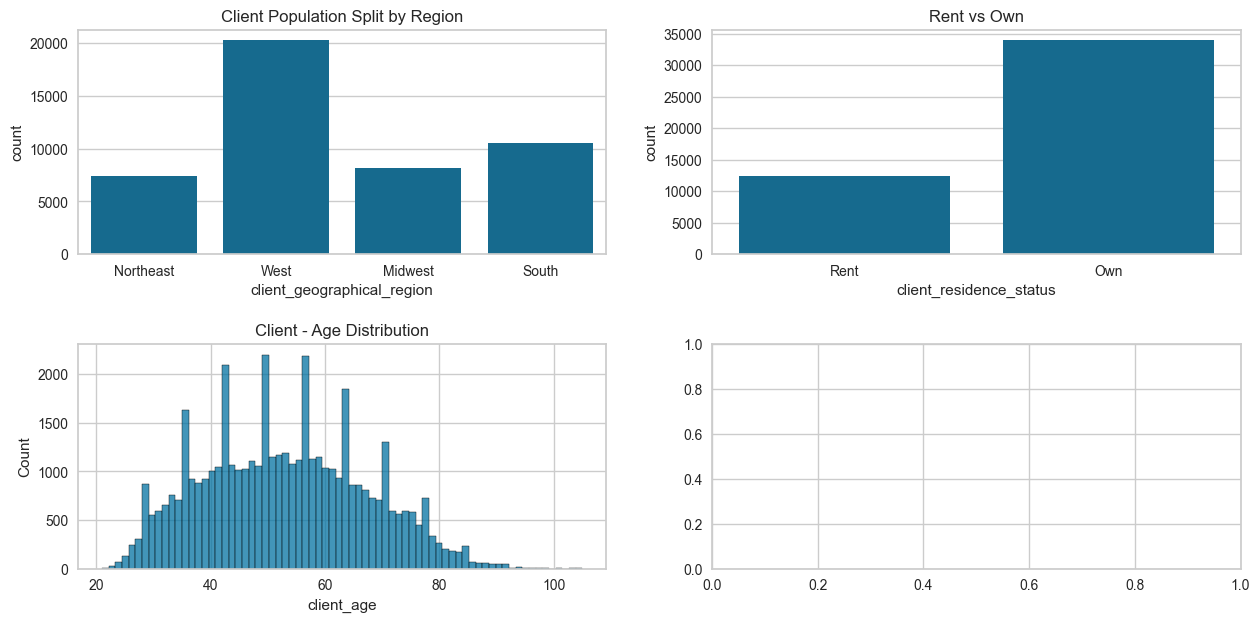

In [9]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
fig.subplots_adjust(hspace=0.4)

sns.countplot(data = df_client, x = 'client_geographical_region', ax= axis[0,0])
sns.countplot(data = df_client, x = 'client_residence_status', ax= axis[0,1])
sns.histplot(data=df_client, x='client_age', ax=axis[1,0])

axis[0,0].set_title('Client Population Split by Region')
axis[0,1].set_title('Rent vs Own')
axis[1,0].set_title('Client - Age Distribution')

plt.show()

### By how much did the monthly deposits go up during the campaign?

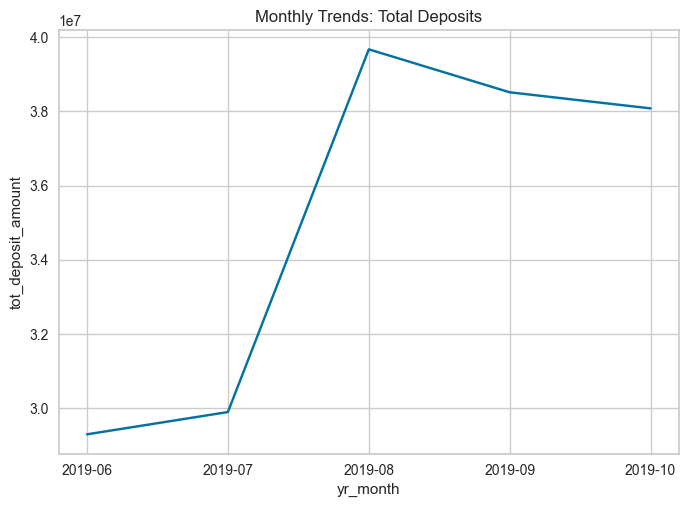

In [56]:
df_deposit_monthly_agg = (
                            df_deposit.groupby(['yr_month'])
                                        .agg(tot_deposit_amount = ('deposit_amount','sum'))
                                        .reset_index()
                            )

sns.lineplot(data=df_deposit_monthly_agg, x='yr_month', y='tot_deposit_amount')

plt.title('Monthly Trends: Total Deposits')

plt.show()

In [64]:
df_deposit_monthly_profit = (
    df_deposit_monthly_agg.assign(prev_month_deposit = lambda x: x['tot_deposit_amount'].shift(1))
                          .assign(dollar_diff = lambda x: (x['tot_deposit_amount'] - x['prev_month_deposit']))
                          .assign(pct_diff = lambda x: (x['dollar_diff']/x['prev_month_deposit']) * 100)
)

df_deposit_monthly_profit

,yr_month,tot_deposit_amount,prev_month_deposit,dollar_diff,pct_diff
0,2019-06,29284830.86,NaN,NaN,NaN
1,2019-07,29886431.27,29284830.86,601600.41,2.054307
2,2019-08,39675057.10,29886431.27,9788625.83,32.752742
3,2019-09,38515819.73,39675057.10,-1159237.37,-2.921829
4,2019-10,38081175.23,38515819.73,-434644.50,-1.128483


In [77]:
baseline = df_deposit_monthly_profit.loc[df_deposit_monthly_profit['yr_month'].isin(['2019-06','2019-07	'])]['tot_deposit_amount'].mean().round(0)


df_deposit_monthly_profit['campaign_profit'] = df_deposit_monthly_profit.apply(lambda x: (x['tot_deposit_amount'] - baseline) if not x['yr_month'] in ['2019-06', '2019-07'] else np.nan, axis = 1)

df_deposit_monthly_profit

total_profit_over_baseline = df_deposit_monthly_profit['campaign_profit'].sum().round(0)

print(f'Total Profit made post campaign (over the pre-campiagn baseline): {total_profit_over_baseline}')

Total Profit made post campaign (over the pre-campiagn baseline): 28417559.0


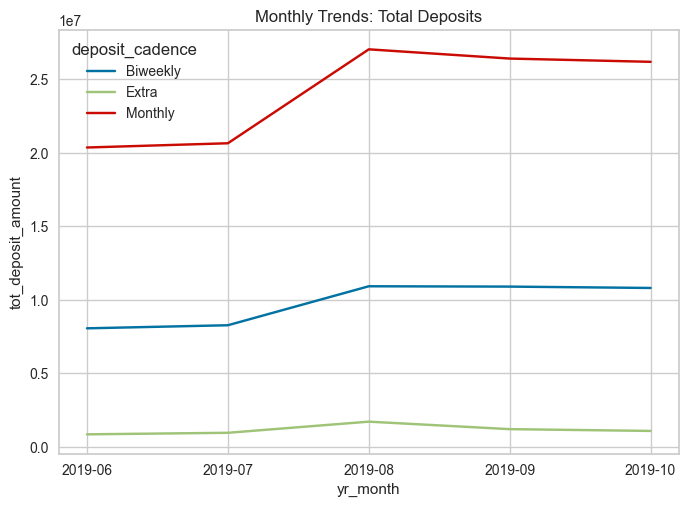

In [55]:
# Plotting deposit amount trends for the different months

df_deposit_monthly_agg = (
                            df_deposit.groupby(['yr_month','deposit_cadence'])
                                                                                    .agg(tot_deposit_amount = ('deposit_amount','sum'))
                                                                                    .reset_index()
                            )

sns.lineplot(data=df_deposit_monthly_agg, x='yr_month', y='tot_deposit_amount', hue='deposit_cadence')

plt.title('Monthly Trends: Total Deposits')

plt.show()

In [10]:
df_deposit.head()

,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date
0,446495122764671,Actual Deposit,303.0,Monthly,2019-10-23
1,446495122764671,Actual Deposit,303.0,Monthly,2019-09-23
2,446495122764671,Scheduled Deposit,303.0,Monthly,2019-09-23
3,446495122764671,Scheduled Deposit,303.0,Monthly,2019-10-23
4,446495122764671,Scheduled Deposit,303.0,Monthly,2019-06-23


In [21]:
df_first_deposit_month = (
    df_deposit.groupby(['client_id']).agg(first_deposit_month = ('month','min'))
                                     .reset_index()
)


df_deposit = df_deposit.merge(df_first_deposit_month,
                              how='left',
                              left_on='client_id',
                              right_on='client_id')

df_deposit.head()


,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date,yr_month,month,first_deposit_month
0,446495122764671,Actual Deposit,303.0,Monthly,2019-10-23,2019-10,10,6
1,446495122764671,Actual Deposit,303.0,Monthly,2019-09-23,2019-09,9,6
2,446495122764671,Scheduled Deposit,303.0,Monthly,2019-09-23,2019-09,9,6
3,446495122764671,Scheduled Deposit,303.0,Monthly,2019-10-23,2019-10,10,6
4,446495122764671,Scheduled Deposit,303.0,Monthly,2019-06-23,2019-06,6,6


In [29]:
df_first_deposit_per_client = df_deposit[['client_id','first_deposit_month']].drop_duplicates()

df_first_deposit_per_client = df_first_deposit_per_client.loc[df_first_deposit_per_client['first_deposit_month']>=7]


(
    df_first_deposit_per_client.groupby(['first_deposit_month']).agg(new_customer_count=('client_id', 'nunique'))
                                                                .reset_index()
                                                                .assign(prev_month_count = lambda x: x['new_customer_count'].shift(1))
                                                                .assign(pct_diff = lambda x: ((x['new_customer_count'] - x['prev_month_count'])/x['prev_month_count']) * 100)
)


,first_deposit_month,new_customer_count,prev_month_count,pct_diff
0,7,1911,NaN,NaN
1,8,11544,1911.0,504.081633
2,9,558,11544.0,-95.166320
3,10,194,558.0,-65.232975


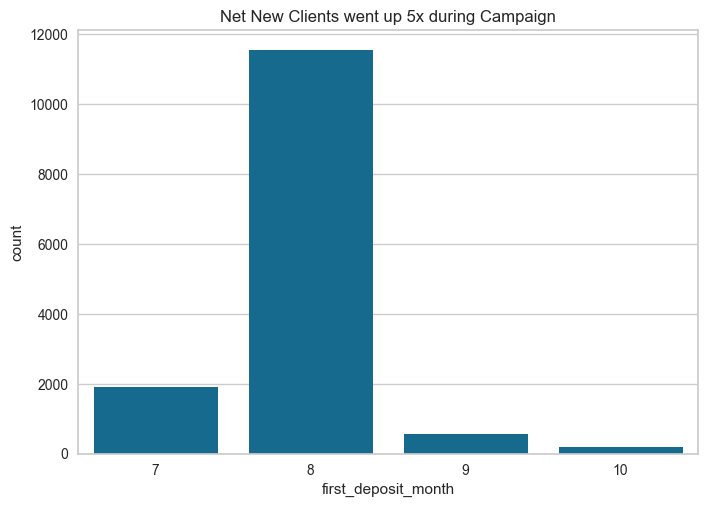

In [30]:
sns.countplot(data=df_first_deposit_per_client, x='first_deposit_month')

plt.title('Net New Clients went up 5x during Campaign')

plt.show()

The percent of net new clients went up by 5x during the month of the camapign 